## Intro

Having trained several models trained on several different data distributions, let's plot their performace throughout the manifold, and compare to the ground truth function.

This notebook examines peak_broad, trained on a half-disk patch centered near the peak, but broad enough to include other features.

Let's load the python modules and the model, first.

In [1]:
from utils import *
from datafile import *
from betaVAE import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

fname = 'peak_broad'

beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB = get_params(fname)
print([beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB])

L = get_loss(fname)

model = get_model(fname)

beta,latent,datasize,learning_rate,epochs,muW,muB,stdW,stdB

[0.01, 5, 2048, 0.0001, 50000, 1.0, 0.0, 0.1, 0.1]


## Learning

First, let's take a look at the learning curve, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

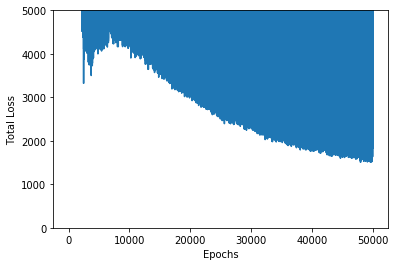

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(L)+1), L)
plt.ylim([0, 5000])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")

fig

It seems unclear whether the loss has plateaued at all; it will be worth rerunning this network with more training. For now, though let's plot what we can.

In [5]:
print(L[-10:])

[2247.920166015625, 6159.09033203125, 9042.4365234375, 2691.0029296875, 2875.13720703125, 2882.526123046875, 3383.545166015625, 19910.193359375, 1985.29345703125, 1837.0775146484375]


## Behavior on Training Data; Metrics

Now that we see that the network is fully trained, let's look at several metrics of its performance on the domain where it was trained.

Let's take a look at the data itself, first.

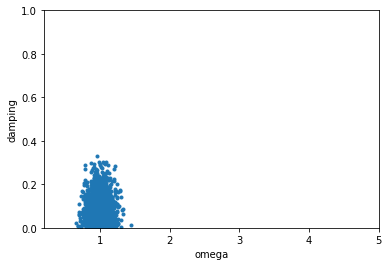

In [3]:
data, groundTruth = datagen(muW, muB, stdW, stdB, datasize)

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlabel("omega")
plt.ylabel("damping")
plt.ylim([0, 1])
plt.xlim([0.2, 5.0])

fig

Now, let's compute the network's output on this data, and then compute some metrics.

In [4]:
d = torch.FloatTensor(data).cuda()

o, mu, _ = model(d)

output = o.cpu().detach().numpy()
means = mu.cpu().detach().numpy()

In [5]:
errors = output - groundTruth

phaseE = errors[:, 0]
ampE = errors[:, 1]

print(errors)

[[-0.00484655 -0.07036863]
 [ 0.01544355 -0.04284401]
 [ 0.02307407  0.02403872]
 ...
 [ 0.03859185  0.21661182]
 [ 0.02208911  0.04693016]
 [ 0.02182678  0.01397817]]


In [6]:
phases = groundTruth[:, 0]
amps = groundTruth[:, 1]

prange = max(phases) - min(phases)
arange = max(amps) - min(amps)

# I average the squared errors because the network is trained to minimize error**2, 
# but I compute the square root so we can compare this to the ranges.
typicalpe = np.sqrt(np.mean(phaseE**2))
typicalae = np.sqrt(np.mean(ampE**2))

print("Typical Phase Error")
print(typicalpe)
print("Typical Amp Error")
print(typicalae)

print("Typical phase error / phase range")
print(typicalpe/prange)
print("Typical amp error / amp range")
print(typicalae/arange)

Typical Phase Error
0.036636905042584655
Typical Amp Error
0.40509823590573213
Typical phase error / phase range
0.011706103064262332
Typical amp error / amp range
0.0045333200379033805


[0.02676657 0.01338567 0.00501408 ... 0.03447208 0.0093384  0.00317282]
0.02709995806988086
1.4569832445463444


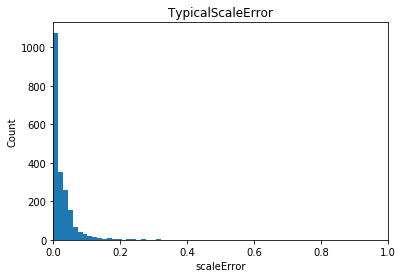

In [8]:
scaleError = abs(ampE)/amps
print(scaleError)
print(np.mean(scaleError))
print(max(scaleError))
fig = plt.figure()
plt.hist(scaleError, 100)
plt.xlim([0, 1])
plt.xlabel("scaleError")
plt.ylabel("Count")
plt.title("TypicalScaleError")
fig

So far, so good. We see the typical error on the data distribution the network was trained on. Later on, we'll also examine how the latent space was used using "means," but for now, let's try to fully understand how well this network understands the underlying function.

## Plots of The Function

### Behavior Near Training Distribution

To begin with, we will plot the groundTruth and the network approximation within the domain where it was trained ($mu \pm 2\sigma $ for $\omega$, between $\mu$ and $mu + 2\sigma$ for $\gamma$) , as well as a distribution of the errors.

In [9]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB + 1e-3 #- 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


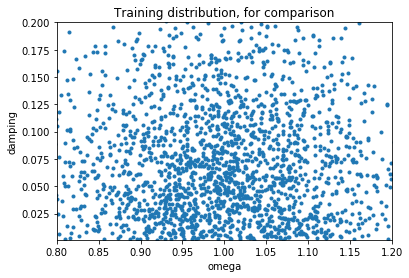

In [10]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [11]:
# Compute the ground truth

Phi = phi(W, B)
A = amplitude(W, B)

In [12]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

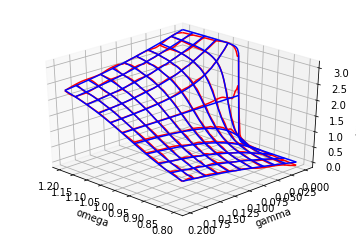

In [13]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")


fig

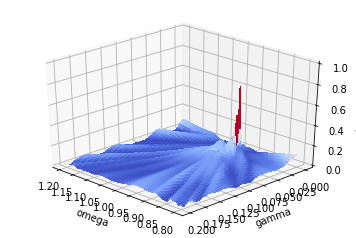

In [14]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

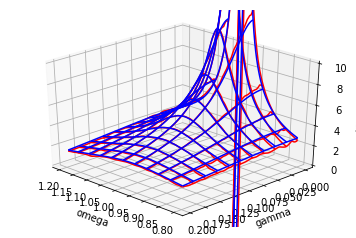

In [15]:
# Plot Ground Truth A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
ax.set_zlim(0, 10)

fig

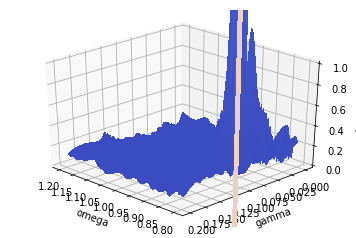

In [16]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

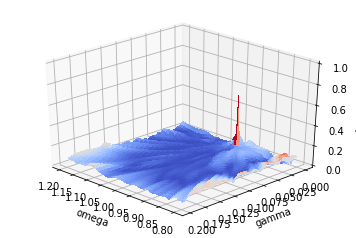

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2)/A, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

### Behavior away from the training distribution

Alright. Now how does the model perform well outside of its original domain?

In [18]:
# Make the data

wmin = 0.2
wmax = 5.0
wstep = (wmax - wmin)/100

bmin = 0.01
bmax = 1.0
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)
print(W.shape)

(101, 100)


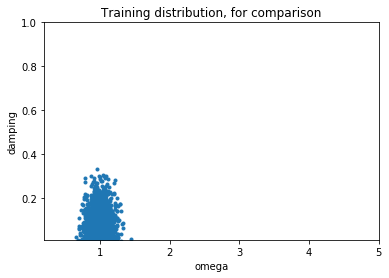

In [19]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [22]:
# Compute the ground truth

Phi = phi(W, B)
A = amplitude(W, B)

In [23]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10100, 1), B.reshape(10100, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(101, 100)
modelA = npo[:, 1].reshape(101, 100)

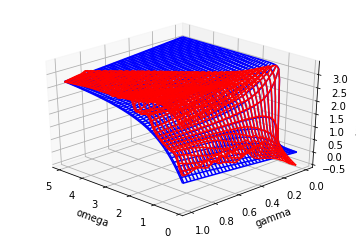

In [24]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")

fig

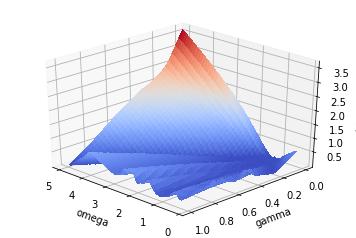

In [25]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")

fig

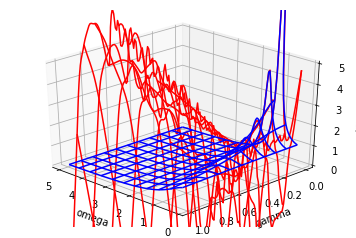

In [26]:
# Plot Ground Truth A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
ax.set_zlim([0, 5])

fig

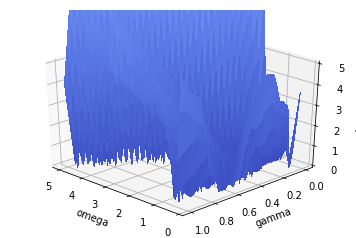

In [27]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 5])

fig

Now that we are looking at the extrapolation potential of the system, let's take a look at the extremes.

In [28]:
print("Max predicted phase")
print(max(modelPhi.reshape((10100,))))
print("Min predicted phase")
print(min(modelPhi.reshape((10100,))))
print("Max predicted amplitude")
print(max(modelA.reshape((10100,))))
print("Min predicted amplitude")
print(min(modelA.reshape((10100,))))

print("\n\n")

print("Max true phase")
print(max(Phi.reshape((10100,))))
print("Min true phase")
print(min(Phi.reshape((10100,))))
print("Max true amplitude")
print(max(A.reshape((10100,))))
print("Min true amplitude")
print(min(A.reshape((10100,))))

Max predicted phase
3.4153085
Min predicted phase
-0.52958053
Max predicted amplitude
25.284546
Min predicted amplitude
-56.62103



Max true phase
3.1373822065713624
Min true phase
0.004166642554263516
Max true amplitude
26.230985251581906
Min true amplitude
0.03918141559633489


## Latent Space

Let's now look at the latent dimensions. Let's first see which are used at all during validation.

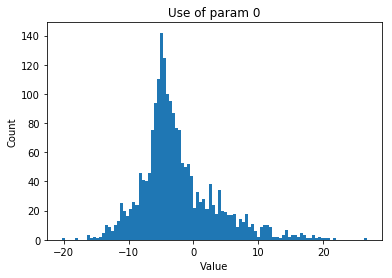

In [29]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 0], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 0")
fig

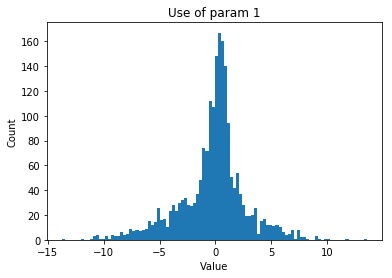

In [31]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 1], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 1")
fig

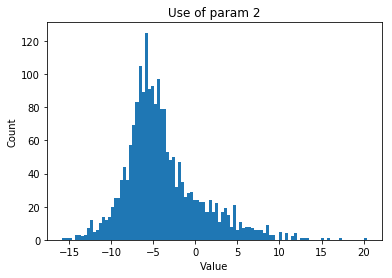

In [32]:
# Param 2

fig = plt.figure()
plt.hist(means[:, 2], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 2")
fig

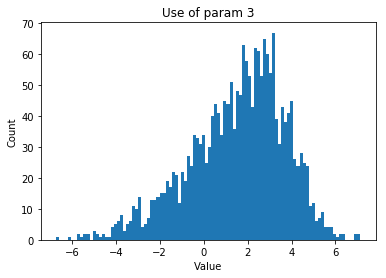

In [33]:
# Param 3

fig = plt.figure()
plt.hist(means[:, 3], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 3")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


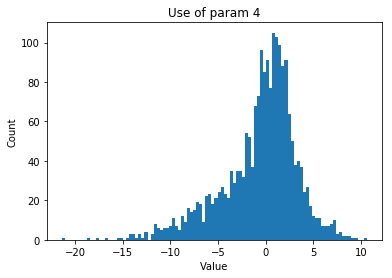

In [35]:
# Param 4

fig = plt.figure()
plt.hist(means[:, 4], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 4")
fig

It seems that, during evaluation, all parameters are used.

Let's plot their dependence on $\omega$ and $\gamma$ within the training distribution.

In [36]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB # - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


In [37]:
# Compute param values

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, params, _ = model(gridpoints)

npm = params.cpu().detach().numpy()
npo = output.cpu().detach().numpy()

param0 = npm[:, 0].reshape(100, 100)
param1 = npm[:, 1].reshape(100, 100)
param2 = npm[:, 2].reshape(100, 100)
param3 = npm[:, 3].reshape(100, 100)
param4 = npm[:, 4].reshape(100, 100)

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


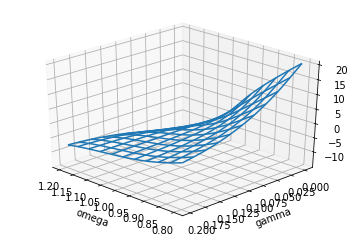

In [38]:
# Plot param 0

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param0, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param0")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


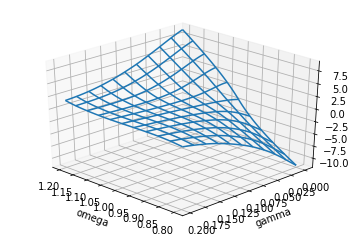

In [39]:
# Plot param 1

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param1, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param1")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


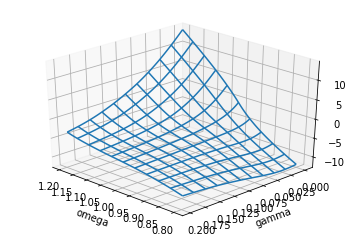

In [40]:
# Plot param 2

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param2, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param2")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


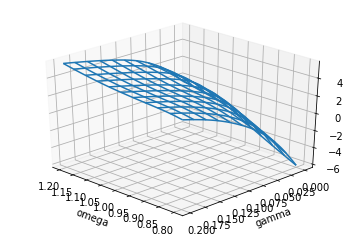

In [41]:
# Plot param 3

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param3, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param3")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


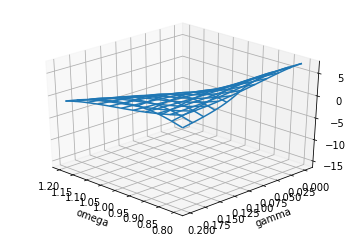

In [42]:
# Plot param 4

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param4, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param3")

fig

In [43]:
# Compute ground truth

Phi = phi(W, B)
A = amplitude(W, B)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


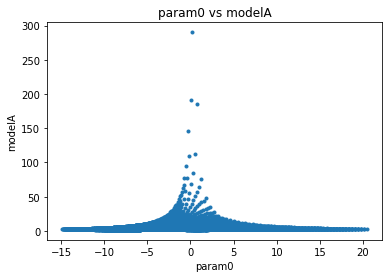

In [45]:
# Compare modelA and param0

fig = plt.figure()
plt.scatter(param0, modelA, marker='.')
plt.title("param0 vs modelA")
plt.xlabel("param0")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


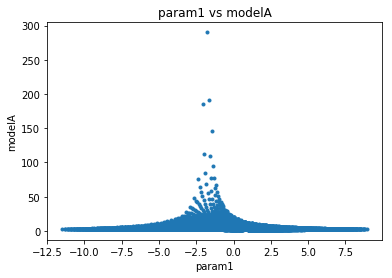

In [46]:
# Compare modelA and param1

fig = plt.figure()
plt.scatter(param1, modelA, marker='.')
plt.title("param1 vs modelA")
plt.xlabel("param1")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


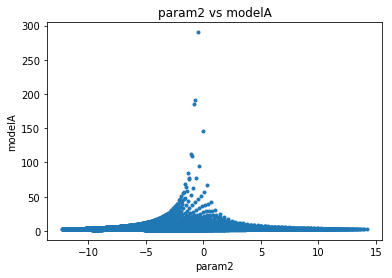

In [47]:
# Compare modelA and param2

fig = plt.figure()
plt.scatter(param2, modelA, marker='.')
plt.title("param2 vs modelA")
plt.xlabel("param2")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


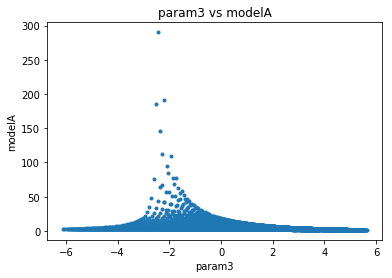

In [48]:
# Compare modelA and param3

fig = plt.figure()
plt.scatter(param3, modelA, marker='.')
plt.title("param3 vs modelA")
plt.xlabel("param3")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


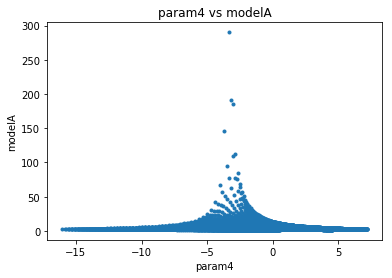

In [49]:
# Compare modelA and param1

fig = plt.figure()
plt.scatter(param4, modelA, marker='.')
plt.title("param4 vs modelA")
plt.xlabel("param4")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


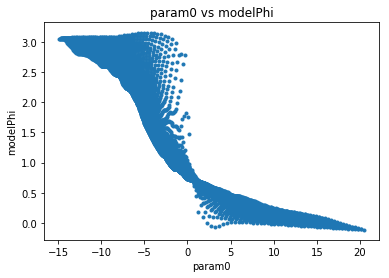

In [54]:
# Compare modelPhi and param0

fig = plt.figure()
plt.scatter(param0, modelPhi, marker='.')
plt.title("param0 vs modelPhi")
plt.xlabel("param0")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


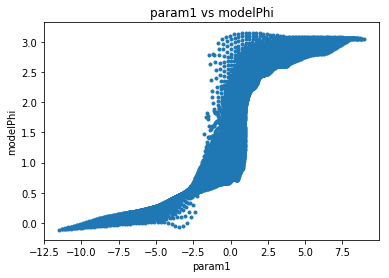

In [51]:
# Compare modelPhi and param1

fig = plt.figure()
plt.scatter(param1, modelPhi, marker='.')
plt.title("param1 vs modelPhi")
plt.xlabel("param1")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


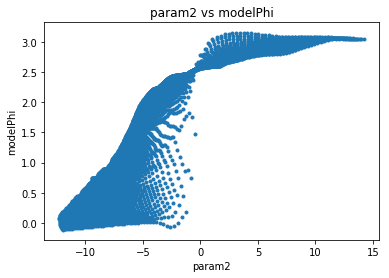

In [52]:
# Compare modelPhi and param2

fig = plt.figure()
plt.scatter(param2, modelPhi, marker='.')
plt.title("param2 vs modelPhi")
plt.xlabel("param2")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


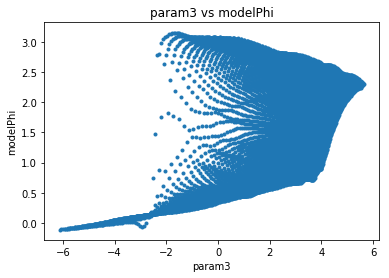

In [53]:
# Compare modelPhi and param3

fig = plt.figure()
plt.scatter(param3, modelPhi, marker='.')
plt.title("param3 vs modelPhi")
plt.xlabel("param3")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


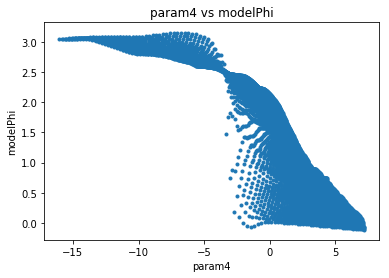

In [50]:
# Compare modelPhi and param4

fig = plt.figure()
plt.scatter(param4, modelPhi, marker='.')
plt.title("param4 vs modelPhi")
plt.xlabel("param4")
plt.ylabel("modelPhi")
fig

## Concluding Thoughts

As with center_very_broad, the network passably mimics the behavior on the training domain, though now the artefacts - rounded corners on the approximation to $\phi(\omega, \gamma)$, higher-frequency noise in the amplitude approximation - can be seen with the naked eye. The graphs of the errors, even in-domain, expose these particularly well (again, the radial lines in the graph of $\phi$ error are particularly stark).

Extrapolation, however, is nearly impossible; the graph is dominated by artefacts (even though, it would seem, all the amplitude function has to learn is to output $0$ on most of its domain).

The parameters are even further from univariate normals, and even harder to interpret in any meaningful way. These are certainly not "natural" parameters.

One of the reasons for this mess, of course, is that sampling near resonance we often see very large amplitudes, but we don't see them often enough to learn a good function exactly - it's very hard to overfit on this region. This is why the real test of SciNet will involve a graph with fractal resolution in this region; we will see whether it can triumph over artefacts.